# Demo Transformer Model para clasificar (atributo clase discreto) o estimar (atributo clase continuo) usando Serie Temporal

Basado en

 https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3

 https://medium.com/mlearning-ai/transformer-implementation-for-time-series-forecasting-a9db2db5c820

 https://keras.io/examples/timeseries/timeseries_transformer_classification/

In [1]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import os
import csv

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [2]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [3]:
#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'CLIMA_nuevo.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Yori, Xori, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Yori = np.array(df[attClase])
  Xori = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", Xori.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Yori.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
Xori = None
Yori = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  CLIMA_nuevo.csv  cargado

> Cabecera: 
   fecha_dia  fecha_mes  temp_prom  temp_min  tem_max  viento_dir  viento_vel  \
0          1          1       24.8      20.6     34.6          15        14.8   
1          2          1       26.4      16.7     35.0         354        10.6   
2          3          1       29.2      21.0     37.2          75        11.2   
3          4          1       28.1      20.7     37.6         231        15.6   
4          5          1       20.6      10.5     31.1         130        16.1   

   presion  precipitacion  
0   1003.6            0.0  
1   1004.6            0.0  
2   1006.7            0.0  
3   1005.9            0.0  
4   1015.4            0.0  

> Características: 
        fecha_dia   fecha_mes   temp_prom    temp_min     tem_max  viento_dir  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean    15.720548    6.526027   17.733836   11.902466   24.531233  151.952055   
std      8.802278    3.4

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo precipitacion como de entrada dado que es clase.

> Atributos entrada:  ['fecha_dia', 'fecha_mes', 'temp_prom', 'temp_min', 'tem_max', 'viento_dir', 'viento_vel', 'presion']
	 X:  (730, 8)

> Atributo clase:  precipitacion
	 Y:  (730,)

Eliminando atributo temp_prom como de entrada dado que es clase.

> Atributos entrada:  ['fecha_dia', 'fecha_mes', 'viento_dir', 'viento_vel', 'presion', 'precipitacion']
	 X:  (730, 6)

> Atributo clase:  temp_prom
	 Y:  (730,)


In [5]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(Xori[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  Xori = scaler.fit_transform(Xori)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(Xori[:10])

10 primeros datos de Entrada antes de normalizar: 
[[-1.67350325 -1.60274527 -1.35168458  0.66082707 -1.92908741 -0.2714402 ]
 [-1.5598184  -1.60274527  1.99416572 -0.39890189 -1.76727725 -0.2714402 ]
 [-1.44613355 -1.60274527 -0.75949869 -0.24751204 -1.42747592 -0.2714402 ]
 [-1.33244871 -1.60274527  0.78018463  0.86268021 -1.55692404 -0.2714402 ]
 [-1.21876386 -1.60274527 -0.21666162  0.98883842 -0.01972754 -0.2714402 ]
 [-1.10507901 -1.60274527 -0.63119175  0.81221692  0.15826363 -0.2714402 ]
 [-0.99139416 -1.60274527 -0.84832657  0.81221692  0.07735856 -0.2714402 ]
 [-0.87770932 -1.60274527 -0.77923822  2.02333573 -0.01972754 -0.2714402 ]
 [-0.76402447 -1.60274527 -0.8976754   1.77101932 -0.1815377  -0.2714402 ]
 [-0.65033962 -1.60274527 -1.18389858 -0.17181711 -0.66696817 -0.2714402 ]]


10 primeros datos de Entrada después de normalizar: 
[[-1.67350325 -1.60274527 -1.35168458  0.66082707 -1.92908741 -0.2714402 ]
 [-1.5598184  -1.60274527  1.99416572 -0.39890189 -1.76727725 -0.271

In [6]:
#@title Generar secuencia de datos como Serie

cantidad_intervalos_secuencia = 3 #@param {type:"integer"}

usar_atributos_secuencia = "Todos" #@param ["Solo atributo a Estimar", "Solo atributos de Entrada", "Todos"]

if cantidad_intervalos_secuencia < 1:
  cantidad_intervalos_secuencia = 1

# funciones auxilliares
def split_sequence(datosX, datosY, n_steps, atr_seq):
  x, y = [], []
  if len(datosX) != len(datosY):
    print("No coincide el largo de los datos X e Y!!!")
    return None, None
  for i in range(len(datosY)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(datosY)-1:
      break
    # gather input and output parts of the pattern
    if atr_seq == "Y":
      # sólo atributo a estimar (anteriores)
      seq_x = datosY[i:end_ix]
      seq_y = datosY[end_ix]
    elif atr_seq == "X":
      # sólo atributos de entrada (anteriores y actuales)
      seq_x = datosX[i:end_ix]
      seq_y = datosY[end_ix-1]
    else:
      # atributos de entrada y a estimar (anteriores)
      seq_xa = datosX[i:end_ix]
      seq_xb = datosY[i:end_ix]
      seq_y = datosY[end_ix]
      seq_x = []
      for xa, xb in zip(seq_xa, seq_xb):
        xa = list(xa)
        xa.append(xb)
        seq_x.append(xa)

    x.append( seq_x )
    y.append( seq_y )
  return np.array(x), np.array(y)

# muestra los primeros "cant" datos
def mostrarEjemplos(X, Y, cant=5):
  for i in range(min(len(X), cant)):
    print(X[i], Y[i])
  print("\n")

print("\n> Antes de generar serie: ")
mostrarEjemplos(Xori, Yori)

# genera secuencias
print("> Generando series con ", cantidad_intervalos_secuencia ," intervalos ")
if (Xori.shape[1] == 0) or usar_atributos_secuencia == "Solo atributo a Estimar":
  atrSeq = "Y"
  cant_atributos_entrada = 1
elif usar_atributos_secuencia == "Solo atributos de Entrada":
  atrSeq = "X"
  cant_atributos_entrada = Xori.shape[1]
else: # "Todos"
  atrSeq = "XY"
  cant_atributos_entrada = Xori.shape[1] + 1
X, Y = split_sequence(Xori, Yori, cantidad_intervalos_secuencia, atrSeq)

print("\n> Después de generar serie: ")
mostrarEjemplos(X, Y)



> Antes de generar serie: 
[-1.67350325 -1.60274527 -1.35168458  0.66082707 -1.92908741 -0.2714402 ] 24.8
[-1.5598184  -1.60274527  1.99416572 -0.39890189 -1.76727725 -0.2714402 ] 26.4
[-1.44613355 -1.60274527 -0.75949869 -0.24751204 -1.42747592 -0.2714402 ] 29.2
[-1.33244871 -1.60274527  0.78018463  0.86268021 -1.55692404 -0.2714402 ] 28.1
[-1.21876386 -1.60274527 -0.21666162  0.98883842 -0.01972754 -0.2714402 ] 20.6


> Generando series con  3  intervalos 

> Después de generar serie: 
[[-1.67350325 -1.60274527 -1.35168458  0.66082707 -1.92908741 -0.2714402
  24.8       ]
 [-1.5598184  -1.60274527  1.99416572 -0.39890189 -1.76727725 -0.2714402
  26.4       ]
 [-1.44613355 -1.60274527 -0.75949869 -0.24751204 -1.42747592 -0.2714402
  29.2       ]] 28.1
[[-1.5598184  -1.60274527  1.99416572 -0.39890189 -1.76727725 -0.2714402
  26.4       ]
 [-1.44613355 -1.60274527 -0.75949869 -0.24751204 -1.42747592 -0.2714402
  29.2       ]
 [-1.33244871 -1.60274527  0.78018463  0.86268021 -1.5569240

In [7]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "continuo - ESTIMACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")


# reshape de [cant ejemplos, datos entrada] into [cant ejemplos, intervalos, datos entrada]
X =  X.reshape((X.shape[0], cantidad_intervalos_secuencia, cant_atributos_entrada))

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)


CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc = to_categorical(y_train)
  y_testEnc = to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, intervalos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, intervalos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de ESTIMACIÓN 


> Para Entrenamiento: 
 - x_train (cant ejemplos, intervalos, datos entrada):  (545, 3, 7)
 - y_train (cant):  545

 Para Prueba: 
 - x_test (cant ejemplos, intervalos, datos entrada):  (182, 3, 7)
 - y_test (cant):  182


# Modelo:

-- se considera salida lineal porque es problema de Estimación!
Modelo creado con  40  capas:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 3, 7)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ trn_nrm_1                 │ (None, 3, 7)           │             14 │ input[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ trn_mha_1                 │ (None, 3, 7)           │         39,687 │ trn_nrm_1[0][0],       │
│ (MultiHeadAttention)      │                        │                │ trn_nrm_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ trn_dp_1 (Dropout)        │ (None, 3, 7)           │              0 │ trn_mha_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_30 (Add)              │ (None, 3, 7)           │              0 │ trn_dp_1[0][0],        │
│                           │                        │                │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffp_nrm_1                 │ (None, 3, 7)           │             14 │ add_30[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffp_cnn_1.1 (Conv1D)      │ (None, 3, 4)           │             32 │ ffp_nrm_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffp_dp_1 (Dropout)        │ (None, 3, 4)           │              0 │ ffp_cnn_1.1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffp_cnn_1.2 (Conv1D)      │ (None, 3, 7)           │             35 │ ffp_dp_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_31 (Add)              │ (None, 3, 7)           │              0 │ ffp_cnn_1.2[0][0],     │
│                           │                        │                │ add_30[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ trn_nrm_2                 │ (None, 3, 7)           │             14 │ add_31[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ trn_mha_2                 │ (None, 3, 7)           │         39,687 │ trn_nrm_2[0][0],       │
│ (MultiHeadAttention)      │                        │                │ trn_nrm_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ trn_dp_2 (Dropout)        │ (None, 3, 7)           │              0 │ trn_mha_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_32 (Add)              │ (None, 3, 7)           │              0 │ trn_dp_2[0][0],        │
│                           │                        │                │ add_31[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffp_nrm_2                 │ (None, 3, 7)           │             14 │ add_32[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 199,231 (778.25 KB)

 Trainable params: 199,231 (778.25 KB)

 Non-trainable params: 0 (0.00 B)

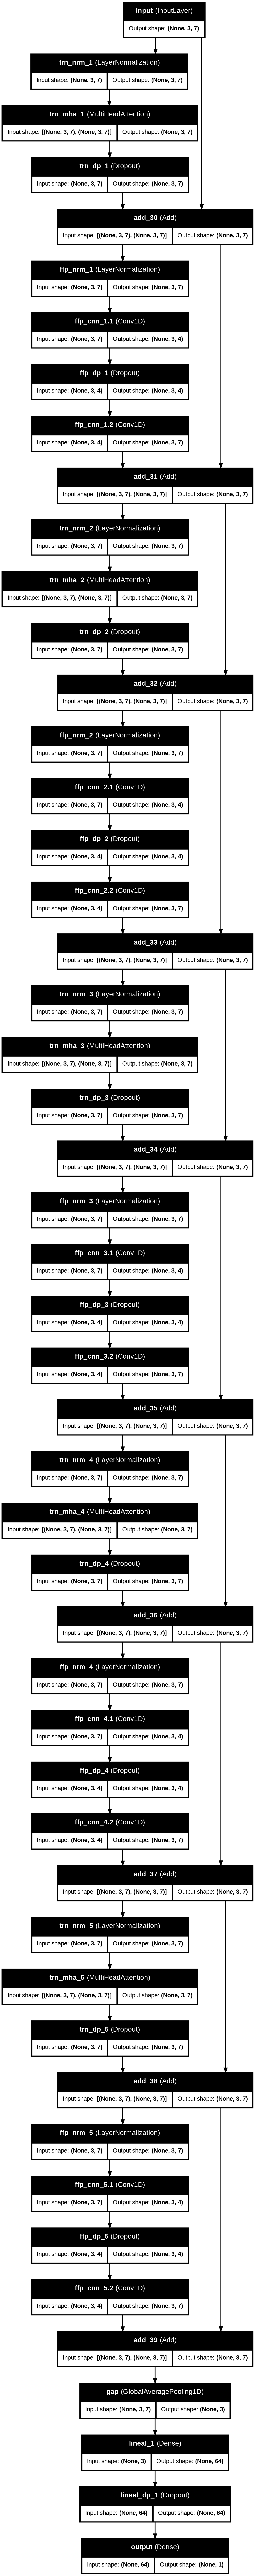

In [11]:
#@title Establecer modelo

#@markdown ### Parámetros para capas Transformer:
trnsf_cant_bloques = 5 #@param {type: "integer"}
trnsf_MultiHeadAttention_head_size = 256 #@param {type: "integer"}
trnsf_MultiHeadAttention_num_heads = 5 #@param {type: "integer"}
trnsf_Conv1D_cant_filters = 4 #@param {type: "integer"}
trnsf_porc_capa_DropOut = 0.25 #@param {type:"number"}

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = '64' #@param {type:"string"}
lineal_porc_capa_DropOut = 0.3 #@param {type:"number"}

#@markdown ### Parámetros de la capa de Salida:
red_tipo_capa_salida = 'lineal-Numero' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.0005 #@param {type: "number"}

# aplica parámetros

if trnsf_MultiHeadAttention_head_size < 1:
  trnsf_MultiHeadAttention_head_size = 1

if trnsf_MultiHeadAttention_num_heads < 1:
  trnsf_MultiHeadAttention_num_heads = 1

if trnsf_cant_bloques < 1:
  trnsf_cant_bloques = 1

# cantidad de neuronas ocultas
hidden_layers = []
for val in lineal_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  if val.isnumeric():
    hidden_layers.append( int(val) )
  else:
    print("Capa ", val, "descartada!")

# chequea configuración de drop out
if trnsf_porc_capa_DropOut <= 0:
  trnsf_porc_capa_DropOut = 0.10
elif trnsf_porc_capa_DropOut > 0.9:
    trnsf_porc_capa_DropOut = 0.9

# chequea configuración de drop out
if lineal_porc_capa_DropOut <= 0:
  lineal_porc_capa_DropOut = 0.10
elif lineal_porc_capa_DropOut > 0.9:
    lineal_porc_capa_DropOut = 0.9

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if esProblemaClasificacion:
  tipo_output_softMax = (red_tipo_capa_salida[:7] == 'softmax')
else:
  print("-- se considera salida lineal porque es problema de Estimación!")
  tipo_output_softMax = False

# funciones auxiliares para crear el modelo
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, layname_sub=0):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="trn_nrm_"+str(layname_sub))(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout, name="trn_mha_"+str(layname_sub)
    )(x, x)
    x = tf.keras.layers.Dropout(dropout, name="trn_dp_"+str(layname_sub))(x)
    res = x + inputs
    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="ffp_nrm_"+str(layname_sub))(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", name="ffp_cnn_"+str(layname_sub)+".1")(x)
    x = tf.keras.layers.Dropout(dropout, name="ffp_dp_"+str(layname_sub))(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, name="ffp_cnn_"+str(layname_sub)+".2")(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    output_softMax_num_Clases=0,
):
    inputs = keras.Input(shape=input_shape, name="input")
    # agrega bloques transfomer
    x = inputs
    for n in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, (n+1))

    # genera un flatten especial
    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first", name="gap")(x)

    # agrega bloques lineales
    i = 1
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu", name="lineal_"+str(i))(x)
        x = tf.keras.layers.Dropout(mlp_dropout, name="lineal_dp_"+str(i))(x)
        i = i + 1

    if output_softMax_num_Clases <= 0:
      # se genera una capa lineal con una salida numérica
      outputs = tf.keras.layers.Dense(1, activation=None, name='output')(x)
    else:
      # se genera una salida softmax
      outputs = tf.keras.layers.Dense(units = len(CLASES), activation='softmax', name='output')(x)

    return keras.Model(inputs, outputs)

# determina tipo de entrada
input_shape = x_train.shape[1:]

# crea el modelo del Transformer
model = build_model(
    input_shape,
    head_size = trnsf_MultiHeadAttention_head_size, #256,
    num_heads = trnsf_MultiHeadAttention_num_heads, # 4,
    ff_dim =  trnsf_Conv1D_cant_filters, # 4,
    num_transformer_blocks = trnsf_cant_bloques,
    mlp_units = hidden_layers,
    mlp_dropout = lineal_porc_capa_DropOut,
    dropout = trnsf_porc_capa_DropOut,
    output_softMax_num_Clases = (len(CLASES) if tipo_output_softMax else 0),
)

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# genera el modelo
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    if esProblemaClasificacion:
      model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    else:
      model.compile(optimizer=opt, loss='mse', metrics=['RootMeanSquaredError'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


In [12]:
#@title Entrenar

cant_epocas_entrenamiento = 1000 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

activar_corte_por_estabilidad_val_loss = False #@param {type:"boolean"}

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train,
                                       (y_trainEnc if tipo_output_softMax else y_train),
                                       test_size=0.1, shuffle=True)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_val_loss:
  # se agrega un callBack para que corte
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=50,
      verbose=1,
      mode='min',
      baseline=None,
      restore_best_weights=True,
      start_from_epoch=20
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas,
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr)

print("\n>Entrenamiento Finalizado.")



> De los  545 ejemplos de entrenamiento: 
            se usan  490 ejemplos para entrenar 
            y  55 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 307ms/step - RootMeanSquaredError: 18.2635 - loss: 333.6989 - val_RootMeanSquaredError: 18.0380 - val_loss: 325.3704
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - RootMeanSquaredError: 15.9623 - loss: 255.3298 - val_RootMeanSquaredError: 11.6110 - val_loss: 134.8156
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - RootMeanSquaredError: 10.3159 - loss: 107.7802 - val_RootMeanSquaredError: 5.9721 - val_loss: 35.6655
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - RootMeanSquaredError: 7.3461 - loss: 53.9947 - val_RootMeanSquaredError: 4.6433 - val_loss: 21.5599
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - RootMeanSquaredError: 7.1748 - loss: 51.5779 - val_RootMeanSquaredError: 4.3585 - val_loss: 18.9967
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/s

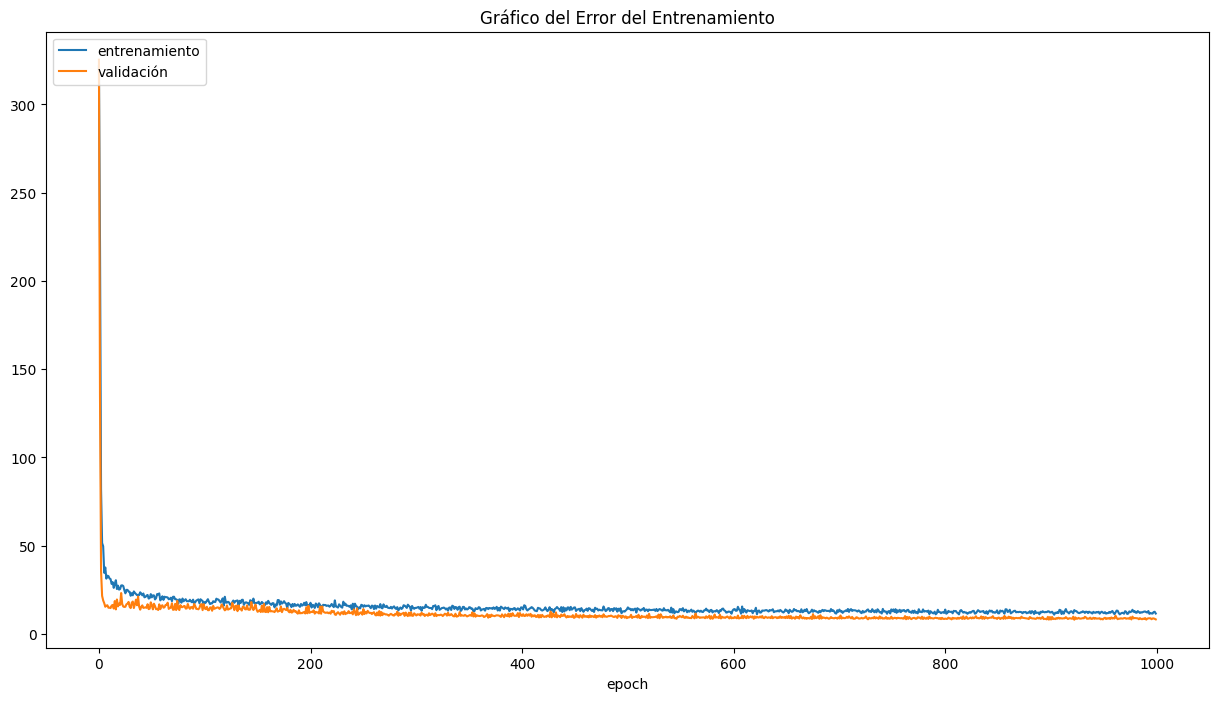

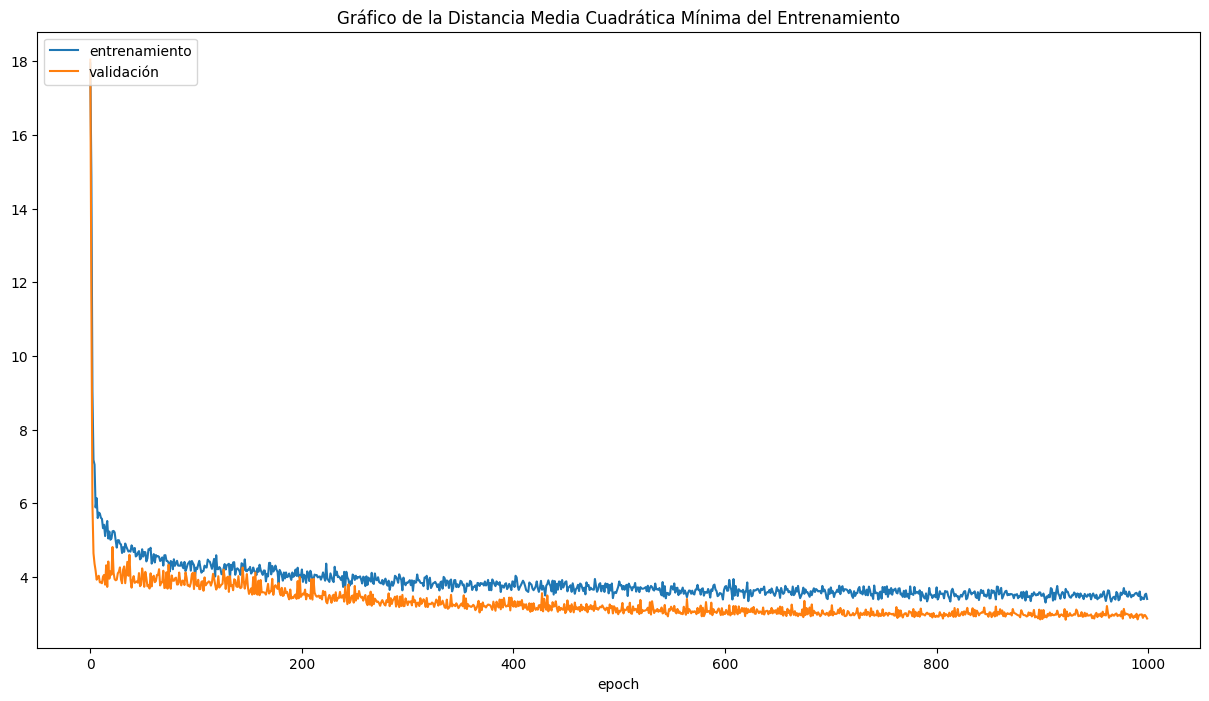

In [14]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8))
if esProblemaClasificacion:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Gráfico de la Exactitud del Entrenamiento')
else:
  plt.plot(history.history['RootMeanSquaredError'])
  plt.plot(history.history['val_RootMeanSquaredError'])
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')

plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

*** Resultados con datos de Entrenamiento: 
 Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]
 R:  19.7000 / M:  20.0975 [   0.3975 |     2.02% ]
 R:  10.5000 / M:  15.8766 [   5.3766 |    51.21% ]
 R:   9.3000 / M:   8.8721 [   0.4279 |     4.60% ]
 R:  19.5000 / M:  16.6320 [   2.8680 |    14.71% ]
 R:  22.5000 / M:  22.0121 [   0.4879 |     2.17% ]
 R:  24.4000 / M:  24.5523 [   0.1523 |     0.62% ]
 R:  23.5000 / M:  21.1652 [   2.3348 |     9.94% ]
 R:  11.5000 / M:  13.3667 [   1.8667 |    16.23% ]
 R:  20.1000 / M:  19.2511 [   0.8489 |     4.22% ]
 R:  19.7000 / M:  20.2645 [   0.5645 |     2.87% ]
 R:  22.5000 / M:  21.5465 [   0.9535 |     4.24% ]
 R:  11.9000 / M:  12.5005 [   0.6005 |     5.05% ]
 R:  13.3000 / M:  13.9332 [   0.6332 |     4.76% ]
 R:  13.8000 / M:  13.0794 [   0.7206 |     5.22% ]
 R:  13.2000 / M:  19.5915 [   6.3915 |    48.42% ]
 R:   8.1000 / M:   9.7661 [   1.6661 |    20.57% ]
 R:  14.9000 / M:  19.0217 [   4.1217 |    27.66% ]
 R:  12.6

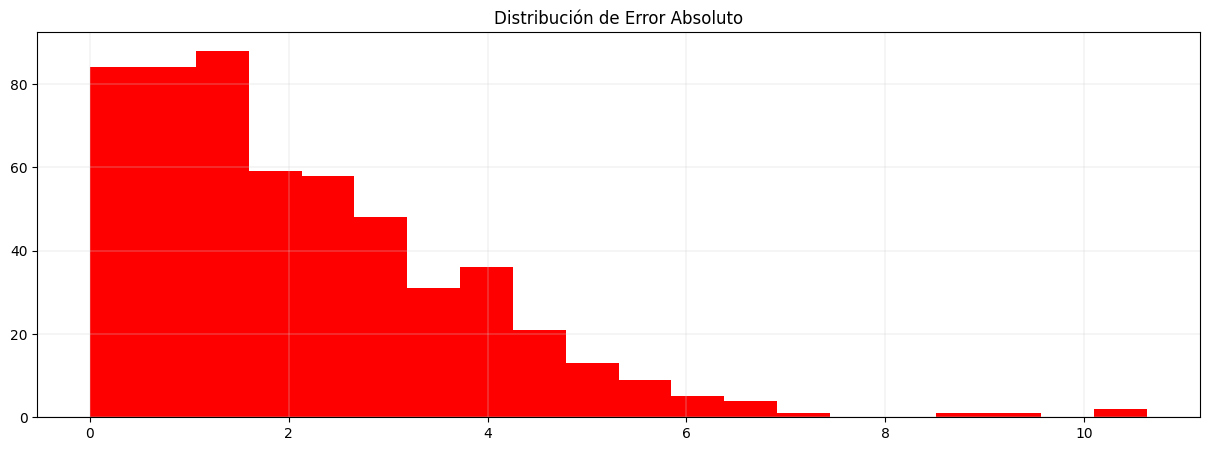


 Error Relativo: 
            Mínimo: 0.01% 
            Promedio: 14.55 ± 15.83
            Máximo: 153.43% 


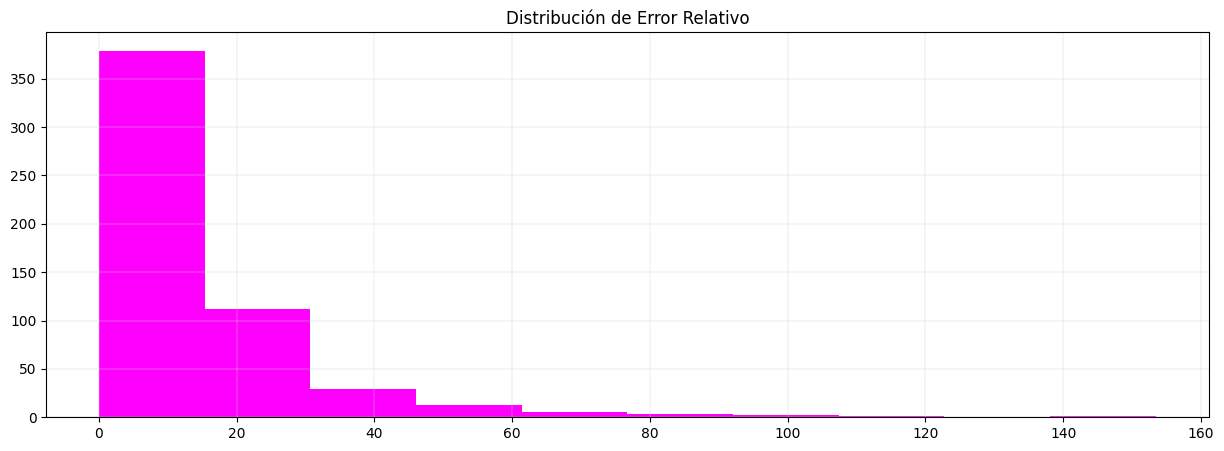

In [15]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
      else:
        print(" Clase Real / Clase Modelo [resultado]")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) +' / M: ' + str(clPred)
        strTitulo = strTitulo + " [ " + ("OK" if (clPred==clReal) else "ERROR!") + " ]"

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, umbral_clasificacion/100.0, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)



>Evaluación del Modelo: 
    - Error:  8.113
    - Distancia Media Cuadrática Mínima:  2.848


*** Resultados con datos de Prueba: 
 Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]
 R:  19.5000 / M:  19.7755 [   0.2755 |     1.41% ]
 R:   9.4000 / M:   7.4941 [   1.9059 |    20.28% ]
 R:   7.9000 / M:   9.1278 [   1.2278 |    15.54% ]
 R:  16.5000 / M:  19.7873 [   3.2873 |    19.92% ]
 R:  25.2000 / M:  22.6618 [   2.5382 |    10.07% ]
 R:  16.8000 / M:  16.5452 [   0.2548 |     1.52% ]
 R:  16.6000 / M:  17.7360 [   1.1360 |     6.84% ]
 R:  12.1000 / M:  14.5433 [   2.4433 |    20.19% ]
 R:  10.2000 / M:  11.0453 [   0.8453 |     8.29% ]
 R:  17.0000 / M:  16.8541 [   0.1459 |     0.86% ]
 R:  11.9000 / M:  13.3136 [   1.4136 |    11.88% ]
 R:  23.9000 / M:  22.4525 [   1.4475 |     6.06% ]
 R:  30.4000 / M:  28.1226 [   2.2774 |     7.49% ]
 R:  14.4000 / M:  12.0085 [   2.3915 |    16.61% ]
 R:  28.1000 / M:  25.3367 [   2.7633 |     9.83% ]
 R:  24.4000 / M:  23.76

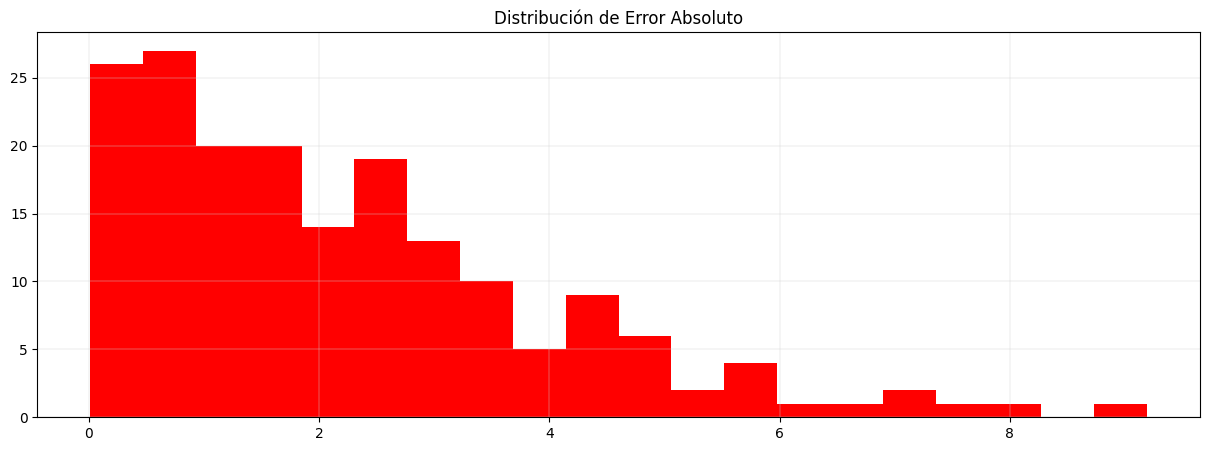


 Error Relativo: 
            Mínimo: 0.05% 
            Promedio: 14.55 ± 15.69
            Máximo: 89.71% 


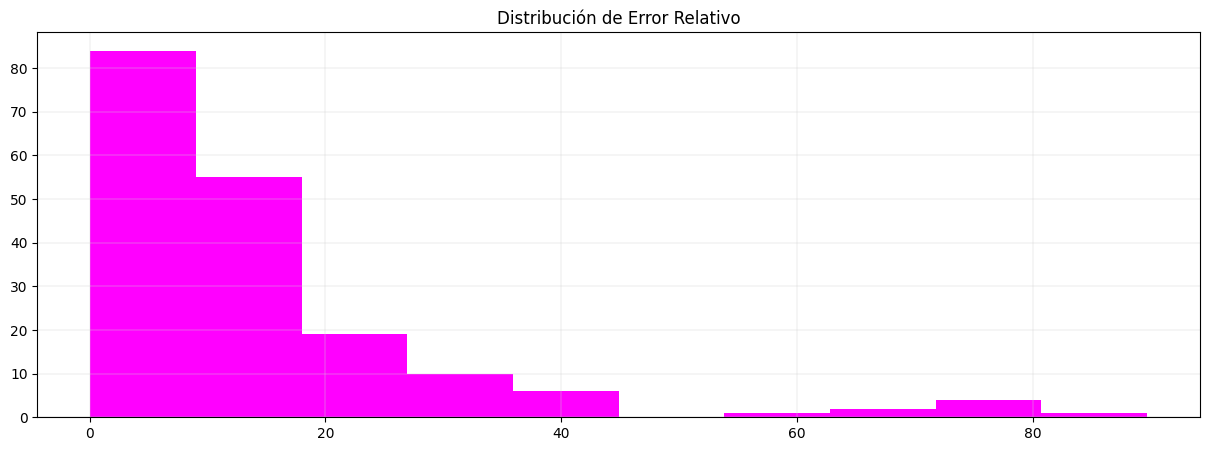

In [16]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = False #@param {type:"boolean"}

  # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test), verbose=0)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", round(resEval[0],3))
if esProblemaClasificacion:
  print("    - Exactitud: ", round(resEval[1]*100,2))
else:
  print("    - Distancia Media Cuadrática Mínima: ", round(resEval[1],3))

#print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, umbral_clasificacion/100.0, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)


In [17]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/datosTRANSFORMER'  #@param {type:"string"}


if guardar_modelo:

    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    model.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")


    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"
      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", fn_scaler,"\n")

    fn_configSeq = path_modelo+"/CONFIG_SECUENCIA.txt"
    with open(fn_configSeq, 'w') as f:
      f.write("cant_atributos_entrada:"+str(cant_atributos_entrada)+"\n")
      f.write("atrSeq:"+str(atrSeq)+"\n")
    print("\n-Configuración de secuencia para preparar los datos guardado en ", fn_configSeq,"\n")

    fn_SPLIT = path_modelo+"/FUNC_SPLIT_SEQUENCE.joblib"
    joblib.dump(split_sequence, fn_SPLIT)
    print("\n-Función split_sequence para preparar los datos de entrada guardado en ", fn_SPLIT,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", fn_clases,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosTRANSFORMER/model.keras 


-SCALER para normalizar datos de entrada guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosTRANSFORMER/SCALER.joblib 


-Configuración de secuencia para preparar los datos guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosTRANSFORMER/CONFIG_SECUENCIA.txt 


-Función split_sequence para preparar los datos de entrada guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosTRANSFORMER/FUNC_SPLIT_SEQUENCE.joblib 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosTRANSFORMER/CLASES_MAP.txt 

